# Backdoor Adjustment Example

## Outline

[Setup](#setup)

[Overview: Systematically adjusting for observed confounding](#overview-systematically-adjusting-for-observed-confounding)
- [Task: Treatment effect estimation with observational data](#task-treatment-effect-estimation-with-observational-data)
- [Challenge: Confounding](#challenge-confounding)
- [Assumptions: All confounders observed](#assumptions-all-confounders-observed)
- [Intuition: Statistically adjusting for confounding](#intuition-statistically-adjusting-for-confounding)

[Example: Evaluating the impact of a job training program](#example-evaluating-the-impact-of-a-job-training-program)
- [Variables](#variables)
- [Motivation](#motivation)
- [Source](#source)

[Causal Probabilistic Program](#causal-probabilistic-program)
- [Model Description](#model-description)
- [Prior Description](#prior-description)
- [Informal Prior Predictive Check: Visualizing Samples](#informal-prior-predictive-check---visualizing-samples)


## Setup

Here, we install the necessary Pytorch, Pyro, and Causal Pyro dependencies for this example.

In [2]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyro.nn import PyroModule, PyroSample
from pyro.poutine import condition, replay, trace

from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer.autoguide.structured import AutoStructured
from pyro.infer import SVI, Trace_ELBO, Predictive

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import MultiWorldCounterfactual

## Overview: Systematically adjusting for observed confounding


### **Task:** Treatment effect estimation with observational data
In this example, we are interested in estimating how changes (or interventions) to a particular treatment variable $T$ influence a particular outcome variable $Y$. We wish to estimate this causal effect using *observational* (non-randomized) data from $T$, $Y$, and some collection of covariates $X = \{X_1, ..., X_d\}$. 

In this example we'll assume that $T$ is a binary random variable, but the concepts carry over exactly when $T$ is continuous or discrete-ordinal.

### **Challenge:** Confounding

Unfortunately, naively estimating the effect of an intervention by simply approximating $P(Y|T)$ alone may produce poor estimates of $T$'s effect on $Y$. In these kinds of *observational* settings, some collection of variables $Z = \{Z_1, ..., Z_{d'}\}$ may influence both $T$ and $Y$, resulting in a statistical dependence that is not reflective of the causal effect we are interested in estimating. These variables are called "confounders", and pose a serious problem for drawing causal conclusions from observational data.

### **Assumptions:** All confounders observed

In this example we assume that all confounders between $T$ and $Y$ are observed. In other words, $Z \subseteq X$.

For technical reasons that are out of scope of this tutorial [@cinelli2020crash], we also assume that no elements of $X$ are common effects of $T$ and $Y$, nor are they influenced by any sets of variables $U_1$, $U_2$ such that $U_1$ influences $T$ and $U_2$ influences $Y$. This somewhat more technical assumption avoids the possibility of "collider bias", also sometimes refered to as "Berkson's paradox". See https://en.wikipedia.org/wiki/Berkson%27s_paradox for more discussion of Berkson's paradox.

### **Intuition:** Statistically adjusting for confounding



If all of the confounders are observed, then we can imagine partitioning our data instances into subsets of instances that have similar values of $X$ and then estimating the statistical dependence between $T$ and $Y$ within each subset of instances. Because we've assumed that $X$ contains all possible confounders, then any remaining statistical dependence must be attributable to $T$'s influence on $Y$. To yield a population-averaged effect estimate, we simply take a weighted average of these subgroup effect estimates where the weights are given by the (estimated) marginal probability of $X$.

Importantly, this "matching" description provides an intuition about how the assumptions result in unbiased statistical inferences of the effect of $T$ on $Y$. In practice, it is often very hard to partition data into explicit subsets of similar units, especially if $X$ is high dimensional. Causal Pyro's approach, in which counterfactual outcomes are imputed using a Bayesian model, also produces unbiased estimates, albeit in a less immediately intuitive way.

## Example: Evaluating the impact of a job training program

### Variables

As a working example, consider the scenario where $T$ represents whether an individual did ($T=1$) or didn't ($T=0$) participate in a job training program, and $Y$ represents their earnings 2 years later. In addition to these measurements, we also gather a collection of covariates $X$ describing each individual's attributes, including academic background, previous earnings, etc. 

### Motivation

Understanding the effect of the job training program on earnings 2 years later may be useful for policymakers who may wish to provide more funding for programs in the future. Providing new funding acts like a kind of intervention, as it changes the mechanism by which individuals choose whether to participate in a job training program. See our [Introductory Tutorial](tutorial_1.ipynb) for a more in-depth discussion of the difference between association and intervention.

### Source

This scenario (and the data we'll use later) come from a real study by Robert Lalonde on the efficacy of training programs, and has become a de facto example for causal inference with observational data [@Lalonde1986evaluating].

Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620

In [3]:
# Load the data
DATA_URL = "https://raw.githubusercontent.com/rugg2/rugg2.github.io/master/lalonde.csv"
data = pd.read_csv(DATA_URL)

# Convert the data to the right format
data["re75"] = data["re75"] / 1000
# Add a small constant to avoid log(0) in the model
data["re78"] = data["re78"] / 1000 + 1e-6
data = data.rename(columns={"educ": "education", "hispan": "hispanic"})

# Define the covariates
covariates_names = ["education", "age", "re75", "black", "hispanic", "married", "nodegree"]

# Extract treatment, covariates and earnings from the dataframe
df = data[["treat", *covariates_names, "re78"]]

# Convert to tensors
covariates_obs = torch.tensor(df[covariates_names].values).float()
training_obs = torch.tensor(df["treat"].values).float()
earnings_obs = torch.tensor(df["re78"].values).float()

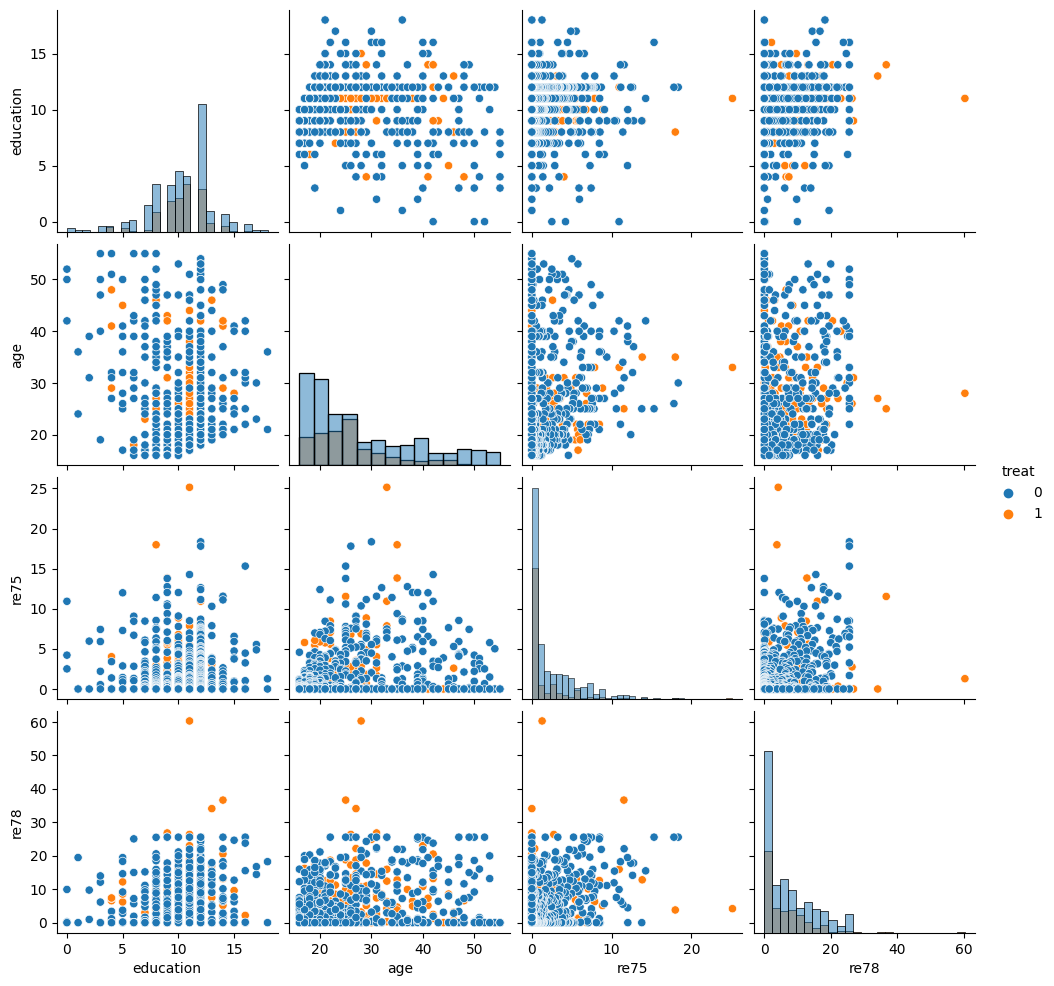

In [4]:
# Visualize the data
sns.pairplot(df[["treat", "education", "age", "re75", "re78"]], hue="treat", diag_kind="hist")

In [5]:
# Evaluate what our answer would be if we just naively predicted the average earnings of treated and untreated individuals, 
# without accounting for the potential confounders.
treated_individuals = df[df["treat"] == 1]
untreated_individuals = df[df["treat"] == 0]

naive_prediction = (treated_individuals["re78"].mean() - untreated_individuals["re78"].mean())
naive_prediction

-0.6350262120374222

## Causal Probabilistic Program

Our causal assumptions can be encoded as a probabilistic program in Pyro. Here, unlike in the [Tutorial](tutorial_i.ipynb), we'll write a probabilistic program in a single pass that includes the causal relationships between attributes and the priors over parameters.

### Model Description

As our assumptions are relatively straightforward, they can be codified entirely in the ordering of random variables in our causal probabilistic program. Specifically, we have written our `causal_model` method below such that `covariates` influence `training` and `earnings`, and `training` influences `earnings`. To align this model with the specific parametric assumptions used in our case study [@lalonde1986evaluating], we have chosen to use a logistic function to describe the mechanism for generating `training` random variables, and a linear Gaussian model for generating `earnings`.

### Prior Description

In order to represent our uncertainty over causal models, we place `Normal`, `HalfCauchy`, and `LKJCholesky` priors on each of the 8 parameters used in our `causal_model`. For each, we choose the prior based on the desired support of the parameter. E.g. variances are strictly positive, therefore we choose a `HalfCauchy` distribution.

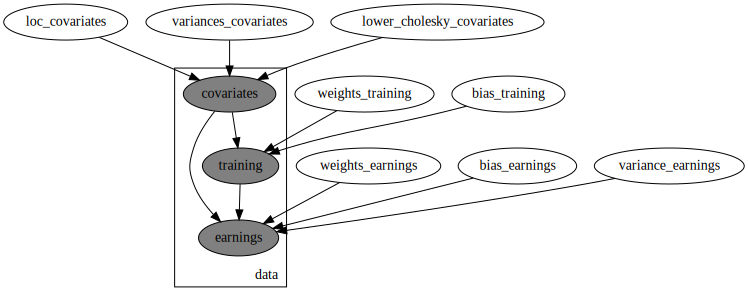

In [23]:
class BayesianBackdoor(PyroModule):
    def __init__(self, n=None, d_covariates=7, include_prior=True):
        super().__init__()
        self.n = n
        self.include_prior = include_prior
        self.d_covariates = d_covariates

    @PyroSample
    def loc_covariates(self):
        loc_prior = torch.concat((torch.tensor([10., 35., 15.]), torch.ones(self.d_covariates-3) * 0.5), dim=0)
        variance_prior = torch.ones(self.d_covariates)
        return dist.Normal(loc_prior, variance_prior).to_event(1)

    @PyroSample
    def variances_covariates(self):
        return dist.HalfCauchy(torch.ones(self.d_covariates)).to_event(1)
        
    @PyroSample
    def lower_cholesky_covariates(self):
        return dist.LKJCholesky(self.d_covariates, 1)

    @PyroSample
    def weights_training(self):
        loc_prior = torch.zeros((self.d_covariates, 1))
        # Attempt to scale weights by variance of covariates
        variance_prior = torch.ones((self.d_covariates, 1)) / torch.concat((torch.tensor([10., 35., 15.]), torch.ones(self.d_covariates-3) * 0.5), dim=0)
        return dist.Normal(loc_prior, variance_prior).to_event(2)

    @PyroSample
    def bias_training(self):
        return dist.Normal(torch.tensor([0.]), torch.tensor([10.])).to_event(1)

    @PyroSample
    def weights_earnings(self):
        loc_prior = torch.zeros((self.d_covariates, 2))
        variance_prior = torch.ones((self.d_covariates, 2)) / torch.concat((torch.tensor([[10., 10.], [35., 35.], [15., 15.]]), torch.ones(self.d_covariates-3, 2) * 0.5), dim=0)
        return dist.Normal(loc_prior, variance_prior).to_event(2)
    
    @PyroSample
    def bias_earnings(self):
        loc_prior = torch.zeros(2)
        variance_prior = torch.ones(2) * 10
        return dist.Normal(loc_prior, variance_prior).to_event(1)
    
    @PyroSample
    def variance_earnings(self):
        return dist.HalfCauchy(torch.ones(2) * 10).to_event(1)

    def causal_model(self,
                    loc_covariates, 
                    variances_covariates,
                    lower_cholesky_covariates, 
                    weights_training, 
                    bias_training, 
                    weights_earnings, 
                    bias_earnings, 
                    variance_earnings):

        # Sample covariates from a multivariate normal distribution     
        scale_tril = torch.diag_embed(variances_covariates.sqrt()) @ lower_cholesky_covariates
        covariates = pyro.sample("covariates", dist.MultivariateNormal(loc_covariates, scale_tril=scale_tril))
        
        # Sample training (treatment) from a logistic function of the covariates
        logit_training = (covariates @ weights_training)[..., 0] + bias_training
        training = (pyro.sample("training", dist.Bernoulli(torch.special.expit(logit_training)))).long()

        # Sample earnings (outcome) from a linear Gaussian function of the covariates and the treatment
        loc_earnings = pyro.ops.indexing.Vindex(covariates @ weights_earnings)[..., training] + bias_earnings[..., training]
        earnings = pyro.sample("earnings", dist.FoldedDistribution(dist.Normal(loc_earnings, variance_earnings[..., training])))
        
        return covariates, training, earnings

    def forward(self, covariates_obs=None, training_obs=None, earnings_obs=None):

        if not covariates_obs is None:
            # Little hack to allow sampling without observations
            n = covariates_obs.shape[0]
        elif not training_obs is None:
            n = training_obs.shape[0]
        elif not earnings_obs is None:
            n = earnings_obs.shape[0]
        else:
            n = self.n


        with pyro.poutine.mask(mask=self.include_prior):
            params = (self.loc_covariates, self.variances_covariates, self.lower_cholesky_covariates, self.weights_training, self.bias_training, self.weights_earnings, self.bias_earnings, self.variance_earnings)

        with pyro.plate("data", n, dim=-1):
            with pyro.condition(data={"covariates": covariates_obs, "training": training_obs, "earnings": earnings_obs}):
                return self.causal_model(*params)

bayesian_backdoor = BayesianBackdoor()
pyro.render_model(bayesian_backdoor, model_args=(covariates_obs, training_obs, earnings_obs))

### Informal Prior Predictive Check - Visualizing Samples

As this model involved several priors over multiple parameters, it is helpful to probe some implications of these modeling decisions on the induced distribution over individual attributes. As we always expect to be conditioning on covariates in our analyses, we only focus on sampling from the prior distribution on `training` and `earnings` random variables conditional on the observed `covariates_obs`.

In [26]:
def plot_predictive(model, covariates_obs, training_obs, earnings_obs, guide=None, compare_source=True, queried=False):

    if guide:
        guide_tr = trace(guide).get_trace(covariates_obs, training_obs, earnings_obs)
        model_tr = trace(replay(model, trace=guide_tr)).get_trace(covariates_obs, training_obs, earnings_obs)
    else:
        model_tr = trace(model).get_trace(covariates_obs, training_obs, earnings_obs)

    covariates = model_tr.nodes['covariates']['value']
    training = model_tr.nodes['training']['value'][:, None]
    # Note: Indexing into counterfactual variables is a little awkward.

    if queried:
        earnings = model_tr.nodes['earnings_observed']['value'][0, 0, :, None]
    else:
        earnings = model_tr.nodes['earnings']['value'][:, None]

    samples = torch.concat((training, covariates, earnings), dim=1).detach().numpy()

    predictive_df = pd.DataFrame(samples, columns=["treat", *covariates_names, "re78"]).astype({"treat":"int8"})

    data_copy = df.copy()
    data_copy["source"] = "data"

    predictive_copy = predictive_df.copy()
    predictive_copy["source"] = "predictive"

    if compare_source:
        sns.pairplot(pd.concat((data_copy, predictive_copy), ignore_index=True)[["treat", "education", "age", "re75", "re78", "source"]], hue="source", diag_kind="hist")
    else:
        sns.pairplot(predictive_df[["treat", "education", "age", "re75", "re78"]], hue="treat", diag_kind="hist")

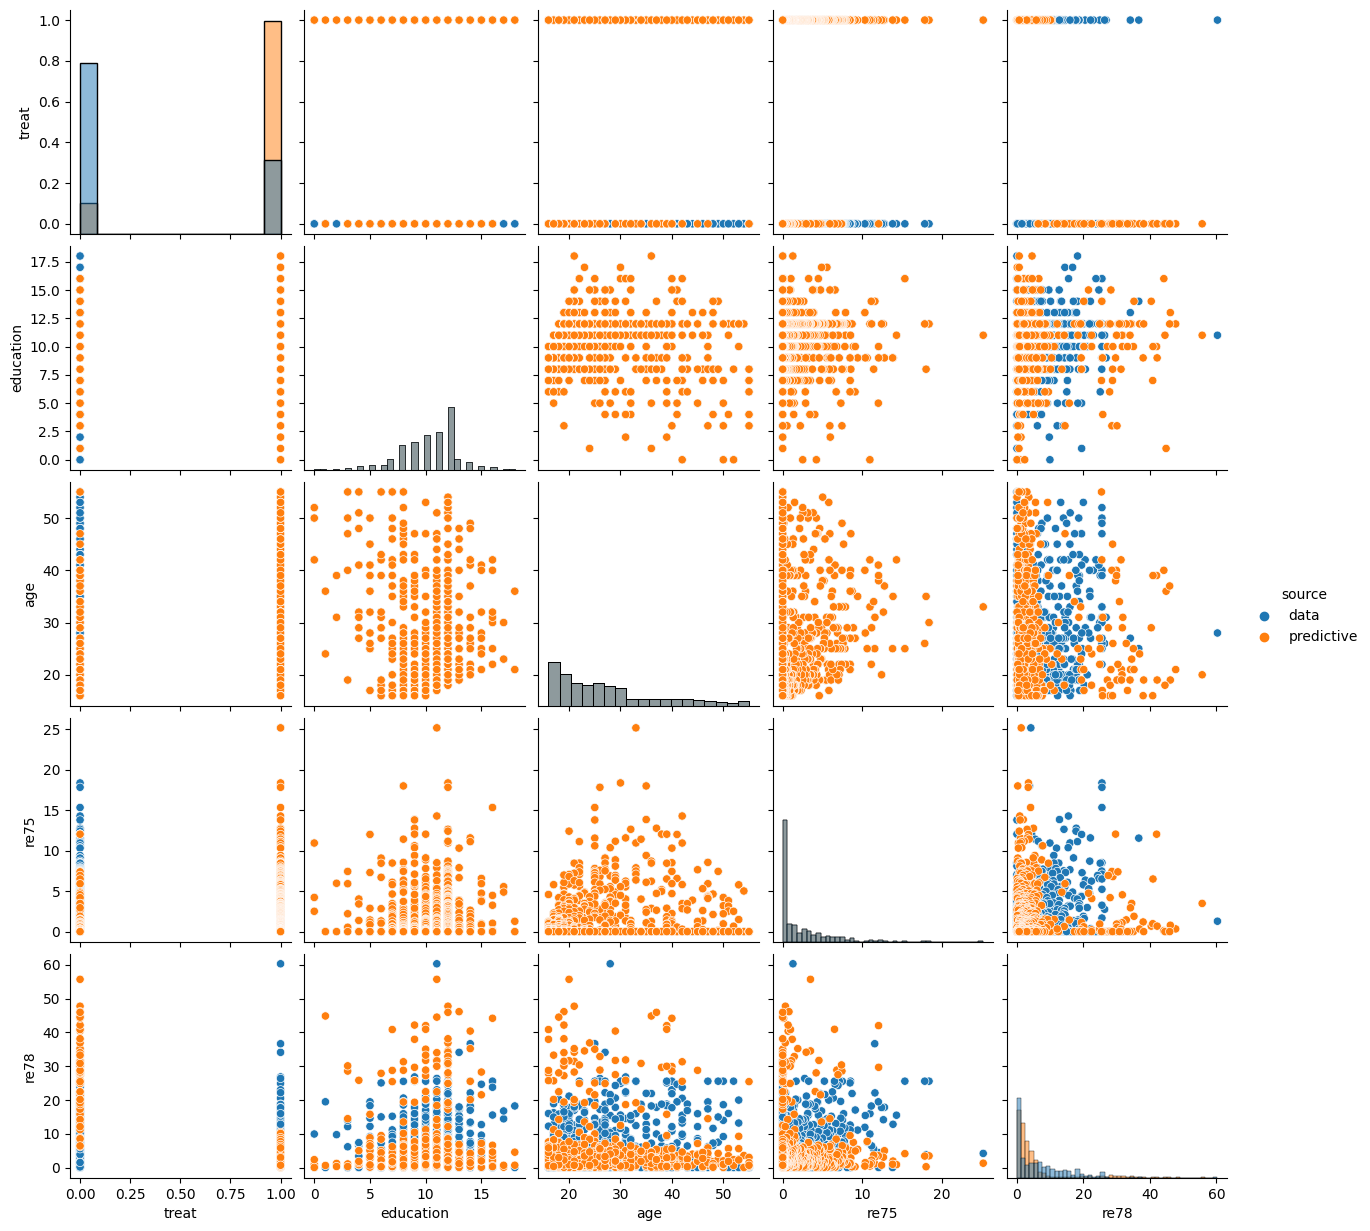

In [27]:
plot_predictive(bayesian_backdoor, covariates_obs, None, None)

## Query: average treatment effect (ATE)

Under these assumptions, we wish to compute the *average treatment
effect*, $ATE = \mathbb{E}[Y=1|do(T=1)] - \mathbb{E}[Y=1|do(T=0)]$. The
`do` notation indicates that the expectations are taken according to
*intervened* versions of the model, with $T$ set to a particular value.
Note that this is different from conditioning on $T$ in the original
`causal_model`, which assumes $X$ and $T$ are dependent.

As in all of our examples in this paper, the estimand of interest (in
this case, the ATE) can be expressed as a posterior expectation in an
*expanded* probabilistic program. (For the simple example in this
section, this is a standard result, see e.g. @pearl and
@lattimore_2019.) 

Suppose we have a set of measurements
$Y^{(i)}, T^{(i)}, X^{(i)}$ from an observational population
distribution $P(Y, T, X)$. The following probabilistic program encodes a
joint distribution over $\theta$, samples from the causal model, and
hypothetical data corresponding to possible experimental outcomes if
random patients were assigned treatment (1) or no treatment (0).
The ATE is the expected return value of the program after conditioning
our uncertainty of the true model parameters $\theta$ on the measured
observational data.

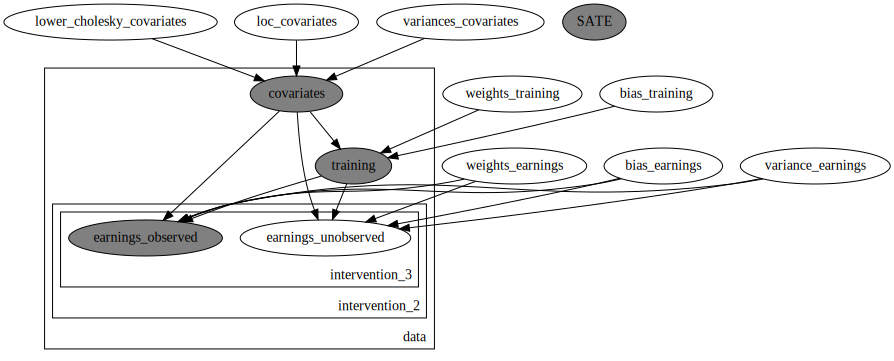

In [7]:
class BayesianBackdoorSATE(PyroModule):
    def __init__(self, n=None, d_covariates=7, include_prior=True):
        super().__init__()
        self.n = n
        self.include_prior = include_prior
        self.d_covariates = d_covariates

    @PyroSample
    def loc_covariates(self):
        # loc_prior = torch.tensor([10., 35., 15., 0.5, 0.5, 0.5, 0.5])
        loc_prior = torch.concat((torch.tensor([10., 35., 15.]), torch.ones(self.d_covariates-3) * 0.5), dim=0)
        # loc_prior = torch.zeros(self.d_covariates)
        variance_prior = torch.ones(self.d_covariates)
        return dist.Normal(loc_prior, variance_prior).to_event(1)

    @PyroSample
    def variances_covariates(self):
        return dist.HalfCauchy(torch.ones(self.d_covariates)).to_event(1)
        
    @PyroSample
    def lower_cholesky_covariates(self):
        return dist.LKJCholesky(self.d_covariates, 1)

    @PyroSample
    def weights_training(self):
        loc_prior = torch.zeros((self.d_covariates, 1))
        # Attempt to scale weights by variance of covariates
        variance_prior = torch.ones((self.d_covariates, 1)) / torch.concat((torch.tensor([10., 35., 15.]), torch.ones(self.d_covariates-3) * 0.5), dim=0)
        return dist.Normal(loc_prior, variance_prior).to_event(2)

    @PyroSample
    def bias_training(self):
        return dist.Normal(torch.tensor([0.]), torch.tensor([10.])).to_event(1)

    @PyroSample
    def weights_earnings(self):
        loc_prior = torch.zeros((self.d_covariates, 2))
        variance_prior = torch.ones((d_covariates, 2)) / torch.concat((torch.tensor([[10., 10.], [35., 35.], [15., 15.]]), torch.ones(d_covariates-3, 2) * 0.5), dim=0)
        return dist.Normal(loc_prior, variance_prior).to_event(2)
    
    @PyroSample
    def bias_earnings(self):
        loc_prior = torch.zeros(2)
        variance_prior = torch.ones(2) * 10
        return dist.Normal(loc_prior, variance_prior).to_event(1)
    
    @PyroSample
    def variance_earnings(self):
        return dist.HalfCauchy(torch.ones(2) * 10).to_event(1)

    def forward(self, covariates_obs, training_obs, earnings_obs):

        if not covariates_obs is None:
            # Little hack to allow sampling without observations
            n = covariates_obs.shape[0]
        elif not training_obs is None:
            n = training_obs.shape[0]
        elif not earnings_obs is None:
            n = earnings_obs.shape[0]
        else:
            n = self.n

        extended_model = do(actions={"training": 0})(
                            do(actions={"training": 1})(
                                pyro.plate("data", n, dim=-1)(
                                        condition(data={"covariates": covariates_obs, "training": training_obs, "earnings": earnings_obs})(
                                                backdoor_cbn))))

        with MultiWorldCounterfactual(-2):
            with pyro.poutine.mask(mask=self.include_prior):
                model_args = (self.loc_covariates, self.variances_covariates, self.lower_cholesky_covariates, self.weights_training, self.bias_training, self.weights_earnings, self.bias_earnings, self.variance_earnings)
            _, _, earnings_cf = extended_model(*model_args)
        
        earnings_treatment = earnings_cf[..., 0, 1, :]
        earnings_control = earnings_cf[..., 1, 0, :]
        return pyro.deterministic("SATE", torch.sum(earnings_treatment - earnings_control, dim=-1) / n)

bayesian_backdoor_sate = BayesianBackdoorSATE()
pyro.render_model(bayesian_backdoor_sate, model_args=(covariates_obs, training_obs, earnings_obs))

## Setting Up Inference and Optimization

In [14]:
# Optimization parameters used throughout
initial_lr = 0.03
adam = pyro.optim.Adam({'lr': initial_lr})
elbo = pyro.infer.Trace_ELBO(num_particles=5, vectorize_particles=True)

In [15]:
def run_inference(covariates_obs, training_obs, earnings_obs, model, guide, optim=adam, loss=elbo, num_predictive_samples=1000, num_iterations=1000, verbose=False):
    svi = SVI(model, guide, optim, loss=loss)
    predictive = Predictive(model, guide=guide, num_samples=num_predictive_samples)

    pyro.clear_param_store()

    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(covariates_obs, training_obs, earnings_obs)
        if verbose:
            if j % 100 == 0:
                print("[iteration %04d] loss: %.4f - SATE estimate: %.2f" % (j + 1, loss / len(covariates_obs), predictive(covariates_obs, training_obs, earnings_obs)['SATE'].mean()))
    
    return predictive(covariates_obs, training_obs, earnings_obs)["SATE"]


## Running Maximum Likelihood Inference

[iteration 0001] loss: 448.4567 - SATE estimate: -3.16
[iteration 0101] loss: 251.9779 - SATE estimate: 0.88
[iteration 0201] loss: 242.3616 - SATE estimate: 1.22
[iteration 0301] loss: 239.6986 - SATE estimate: 1.40
[iteration 0401] loss: 238.5976 - SATE estimate: 1.50
[iteration 0501] loss: 238.0761 - SATE estimate: 1.54
[iteration 0601] loss: 237.7419 - SATE estimate: 1.57
[iteration 0701] loss: 237.5575 - SATE estimate: 1.58
[iteration 0801] loss: 237.4404 - SATE estimate: 1.58
[iteration 0901] loss: 237.3501 - SATE estimate: 1.58


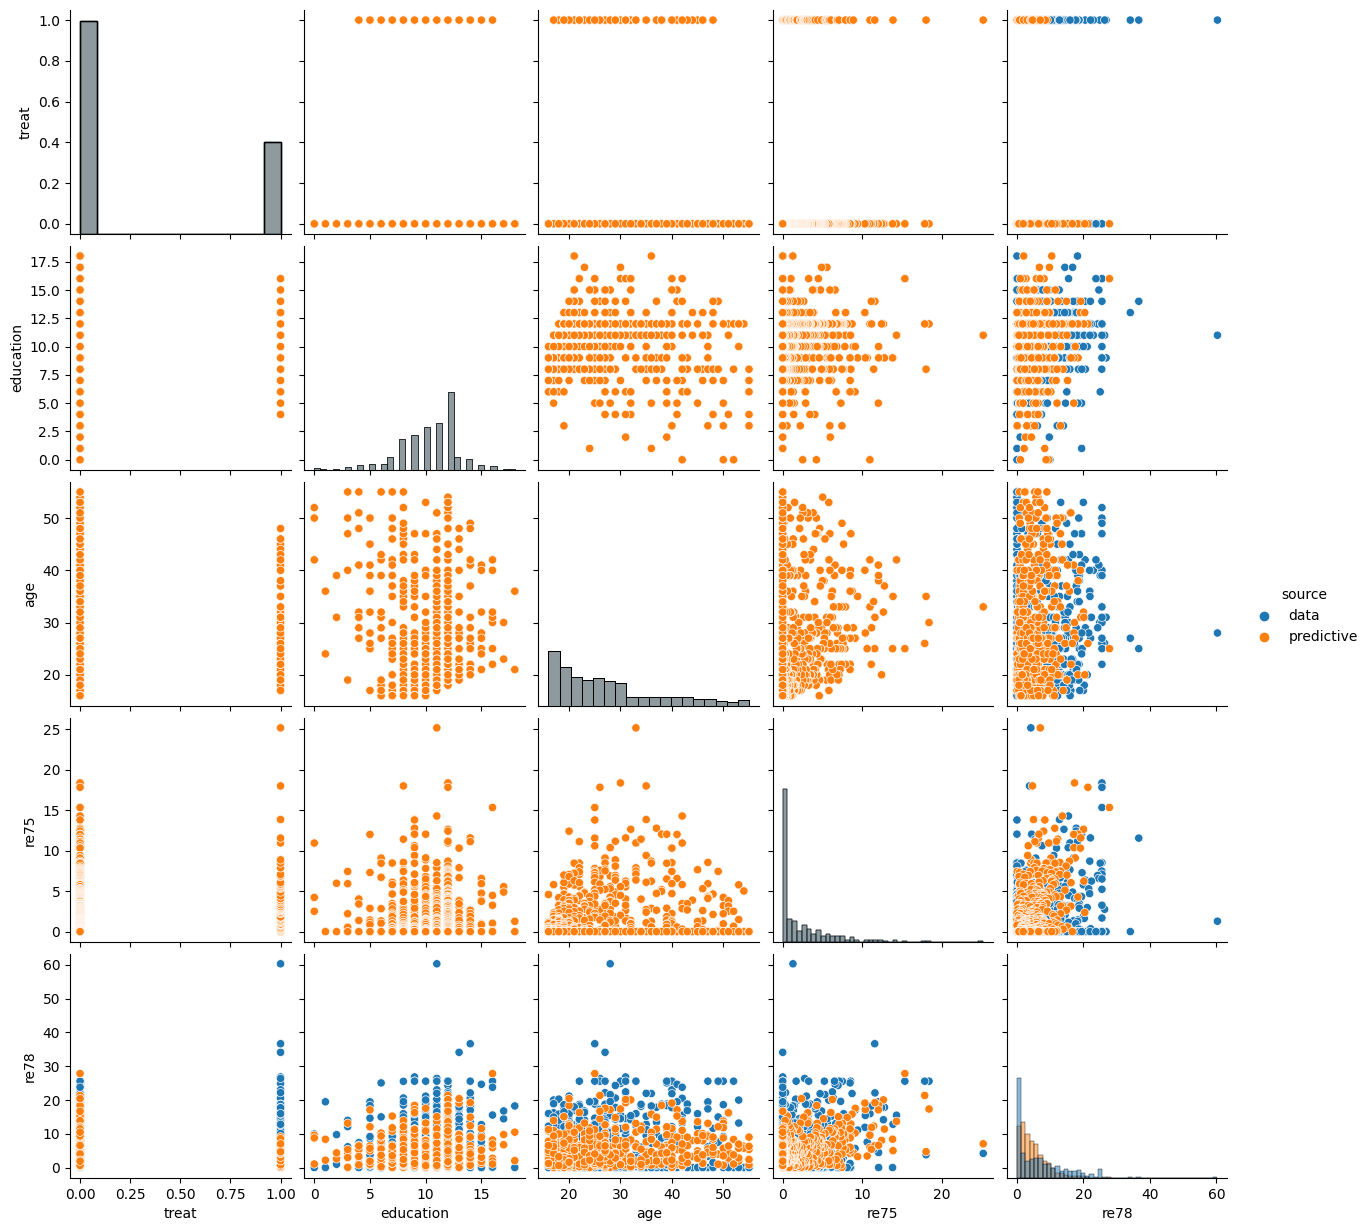

In [16]:
ml_model = BayesianBackdoorSATE(include_prior=False)

ml_guide = AutoDelta(ml_model)

ml_prediction = run_inference(covariates_obs, training_obs, earnings_obs, ml_model, ml_guide, num_predictive_samples=1, verbose=True)

# Visualize posterior predictive sample
plot_predictive(ml_model, covariates_obs, training_obs, None, guide=ml_guide)

## Running MAP Inference

[iteration 0001] loss: 747.2193 - SATE estimate: 2.02
[iteration 0101] loss: 310.3926 - SATE estimate: -4.86
[iteration 0201] loss: 280.3176 - SATE estimate: -5.44
[iteration 0301] loss: 271.0600 - SATE estimate: -5.66
[iteration 0401] loss: 266.3446 - SATE estimate: -5.05
[iteration 0501] loss: 243.7766 - SATE estimate: 0.97
[iteration 0601] loss: 241.2242 - SATE estimate: 1.29
[iteration 0701] loss: 240.3114 - SATE estimate: 1.35
[iteration 0801] loss: 239.7142 - SATE estimate: 1.38
[iteration 0901] loss: 239.2835 - SATE estimate: 1.42


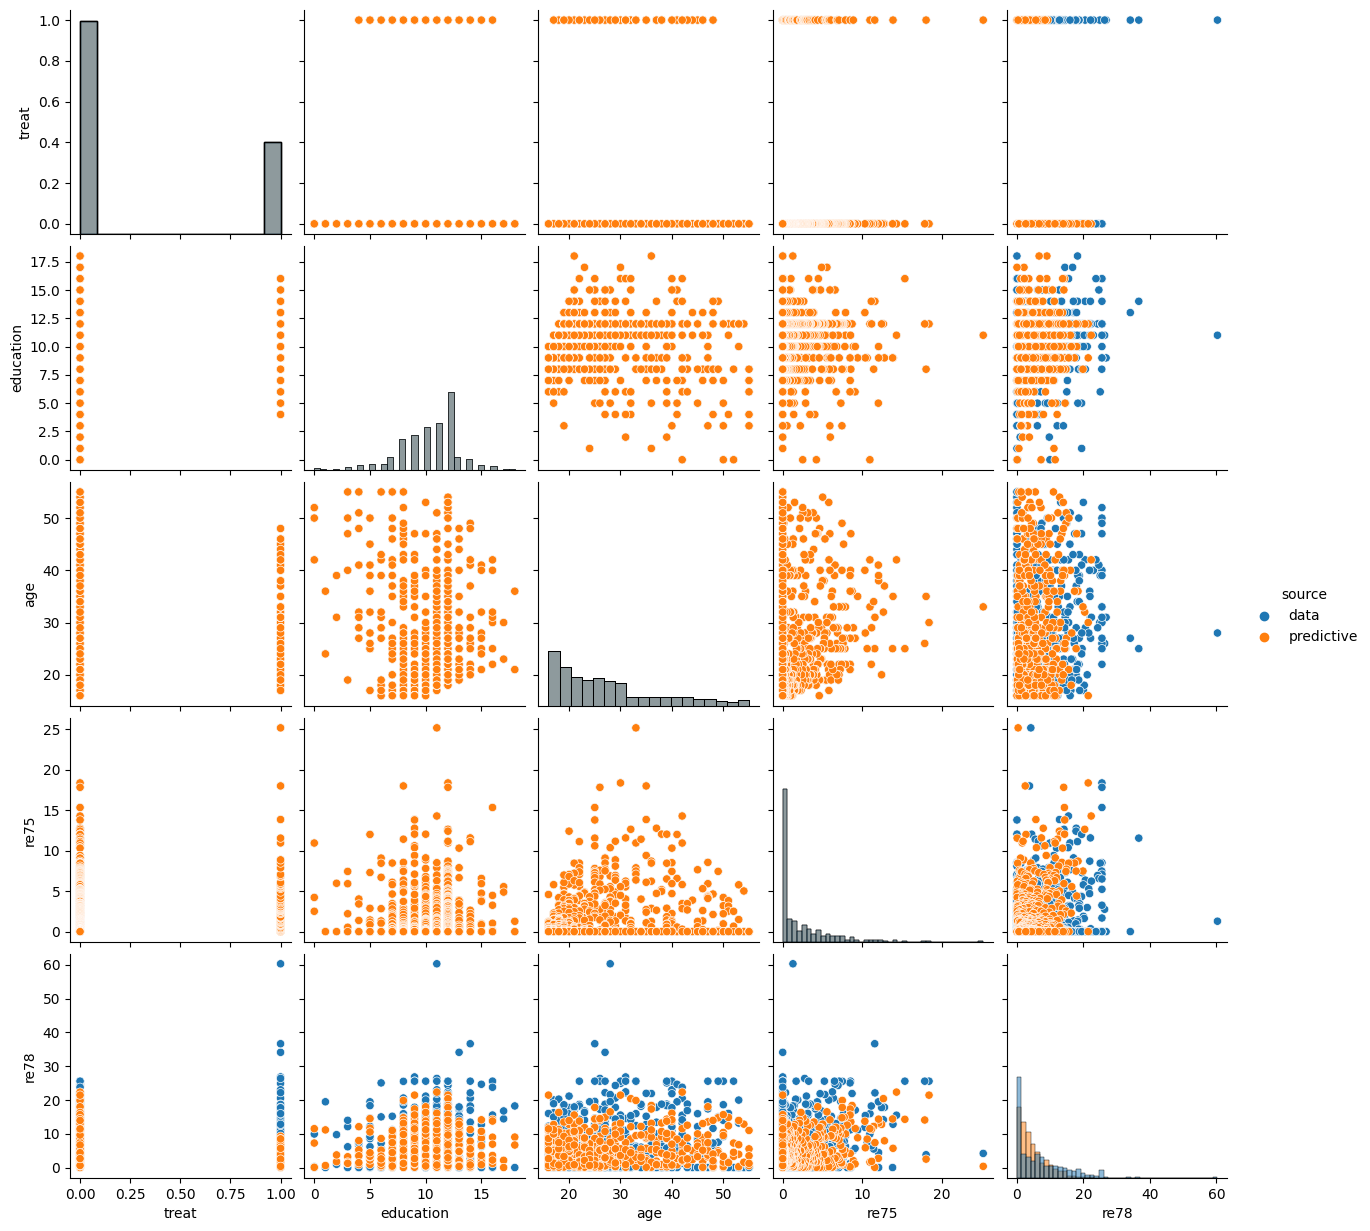

In [17]:
map_model = BayesianBackdoorSATE(include_prior=True)

map_guide = AutoDelta(map_model)

map_prediction = run_inference(covariates_obs, training_obs, earnings_obs, map_model, map_guide, num_predictive_samples=1, verbose=True)

# Visualize posterior predictive sample
plot_predictive(map_model, covariates_obs, training_obs, None, guide=map_guide)

## Running Gaussian Mean Field Inference

In [29]:
# Using default Adam we run into numerical instability problems, and optimization terminates with nans.

gamma = 0.2  # final learning rate will be gamma * initial_lr
num_iterations = 1000
lrd = gamma ** (1 / num_iterations)
clp_adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd}) 

[iteration 0001] loss: 1687.9896 - SATE estimate: 0.01
[iteration 0101] loss: 259.8086 - SATE estimate: 1.10
[iteration 0201] loss: 233.3192 - SATE estimate: 1.14
[iteration 0301] loss: 229.7494 - SATE estimate: 1.26
[iteration 0401] loss: 227.5841 - SATE estimate: 1.33
[iteration 0501] loss: 225.6049 - SATE estimate: 1.38
[iteration 0601] loss: 224.0047 - SATE estimate: 1.40
[iteration 0701] loss: 222.8554 - SATE estimate: 1.45
[iteration 0801] loss: 221.7401 - SATE estimate: 1.47
[iteration 0901] loss: 220.9081 - SATE estimate: 1.49


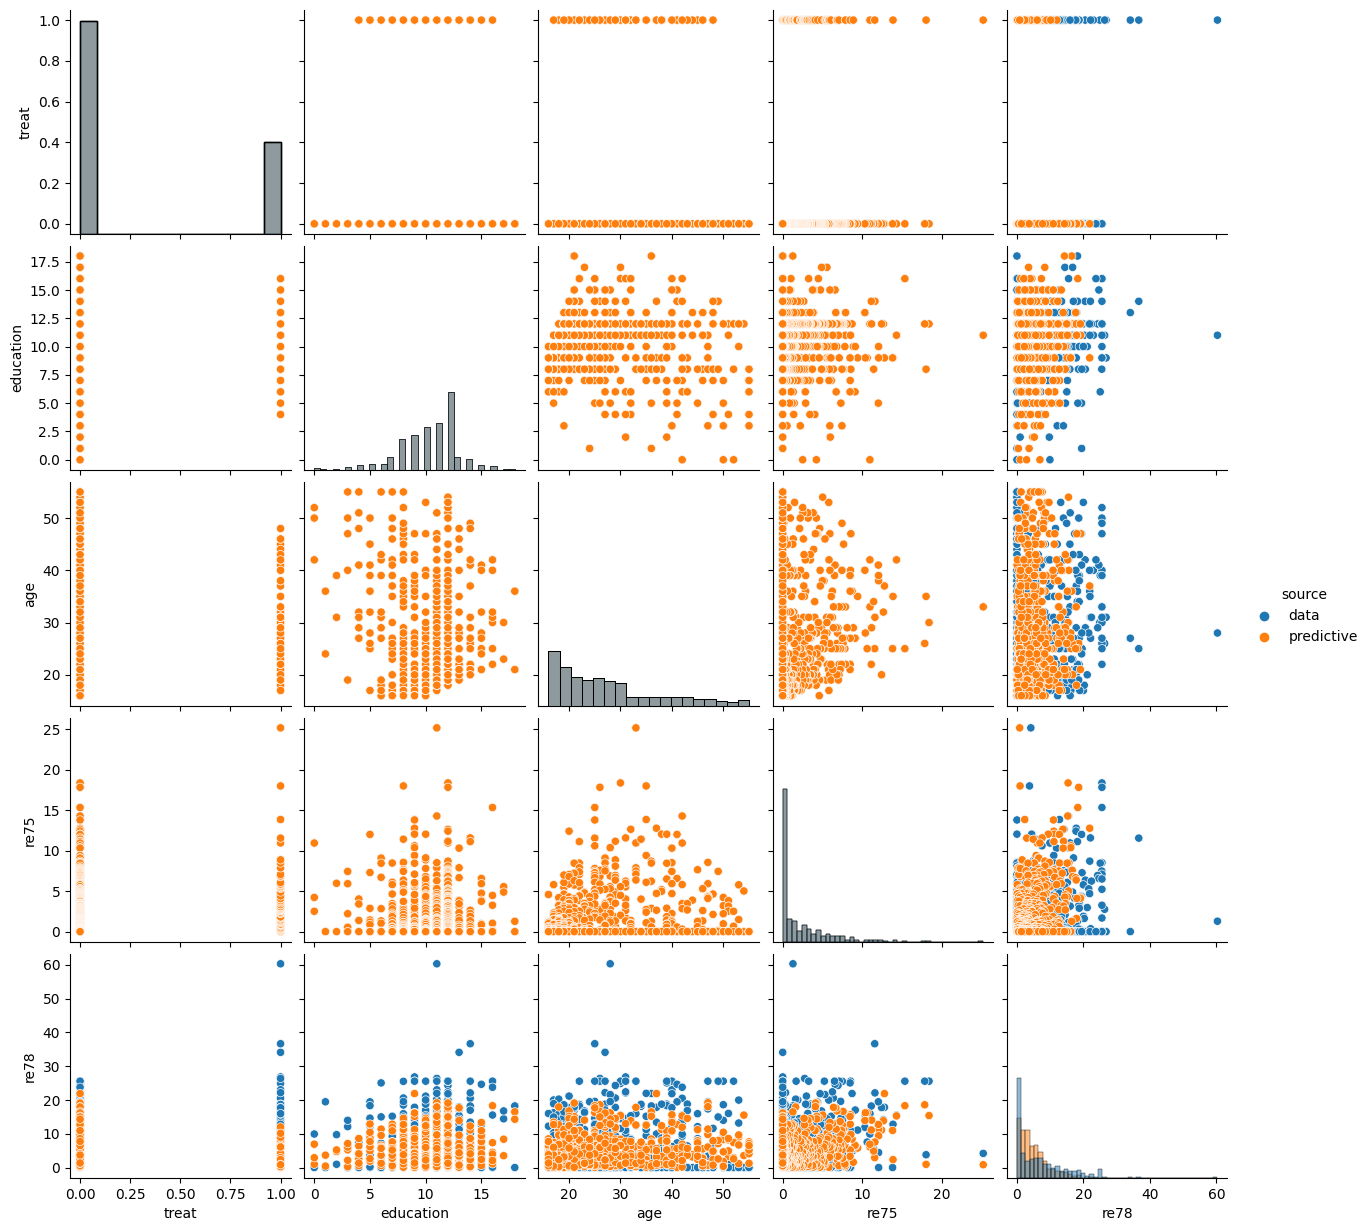

In [30]:
mf_model = BayesianBackdoorSATE(include_prior=True)

# mf_guide = AutoNormal(block(mf_model, hide=["loc_covariates"]))
mf_guide = AutoNormal(mf_model)

mf_prediction = run_inference(covariates_obs, training_obs, earnings_obs, mf_model, mf_guide, optim=clp_adam, num_iterations=num_iterations, verbose=True)

# Visualize posterior predictive sample
plot_predictive(mf_model, covariates_obs, training_obs, None, guide=mf_guide)

## SATE Prediction Comparions

In [31]:
# https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html
blog_prediction = 1548.24 / 1000 # Scaled by 1000 to be consistent with data preprocessing above.

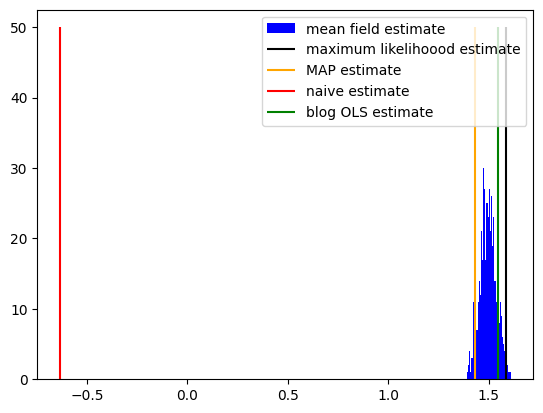

In [32]:
fig, ax = plt.subplots(1, 1)
ax.hist(mf_prediction.squeeze(), bins=100, color="blue", label="mean field estimate")
ax.vlines(ml_prediction.mean(), 0, 50, color="black", label="maximum likelihoood estimate")
ax.vlines(map_prediction.mean(), 0, 50, color="orange", label="MAP estimate")
ax.vlines(naive_prediction, 0, 50, color="red", label="naive estimate")
ax.vlines(blog_prediction, 0, 50, color="green", label="blog OLS estimate")
ax.legend()